<a href="https://colab.research.google.com/github/sunfflur/frequency-learning-DHT/blob/main/kylberg-texture-dataset/Exp_KTD_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet169

`Author:` [sunfflur](https://github.com/sunfflur)

> Exploring DenseNet169 to classify the KTD images. Here we explore two versions of the same model:

1.   Using transfer learning - Pre-trained model.
2.   Without transfer learning - Random initialization.

#### Setup

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

#import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
#import seaborn as sn

#!pip install tensorflow-addons
#!pip install tensorflow-recommenders

#import tensorflow_addons as tfa
#import tensorflow_recommenders as tfrs

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May  3 21:33:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### data loading ###
path_train = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_train.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_train.npy'
path_test = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_test.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_test.npy'

x_train, x_test = np.load(path_train), np.load(path_test)
y_train, y_test = np.load(path_ytrain), np.load(path_ytest)
x_train, x_test = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# adjust dimension and change from array to tensor + convert to 3 channel images
new_shape = (224,224)
x_train, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_test, new_shape)
x_train, x_test = tf.image.grayscale_to_rgb(x_train), tf.image.grayscale_to_rgb(x_test)
y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

In [ ]:
x_train.shape

TensorShape([3360, 224, 224, 3])

#### Pre-trained model

In [ ]:
# prepare the images for the DenseNet model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)

In [ ]:
def pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze.
               0 = all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    densenet_model = DenseNet169(include_top=True,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    if fine_tune > 0:
        for layer in densenet_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in densenet_model.layers:
            layer.trainable = False

    # Turn all the layers trainable.
    '''
    for layer in densenet_model.layers:
      layer.trainable = False
    '''
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = densenet_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)

    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=densenet_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
DenseNet169_model = pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)

58541896/58541896 [==============================] - 0s 0us/step


In [ ]:
print(DenseNet169_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_densenet169_pt.weights.best.hdf5', save_best_only=True, verbose=0)
history = DenseNet169_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 40s 123ms/step - loss: 2.3567 - accuracy: 0.3892 - val_loss: 1.3015 - val_accuracy: 0.8333
Epoch 2/100
189/189 [==============================] - 17s 88ms/step - loss: 0.8693 - accuracy: 0.9246 - val_loss: 0.6132 - val_accuracy: 0.9702
Epoch 3/100
189/189 [==============================] - 17s 88ms/step - loss: 0.4603 - accuracy: 0.9815 - val_loss: 0.3734 - val_accuracy: 0.9970
Epoch 4/100
189/189 [==============================] - 17s 90ms/step - loss: 0.2975 - accuracy: 0.9897 - val_loss: 0.2583 - val_accuracy: 1.0000
Epoch 5/100
189/189 [==============================] - 17s 91ms/step - loss: 0.2121 - accuracy: 0.9934 - val_loss: 0.1918 - val_accuracy: 0.9970
Epoch 6/100
189/189 [==============================] - 17s 89ms/step - loss: 0.1604 - accuracy: 0.9960 - val_loss: 0.1497 - val_accuracy: 1.0000
Epoch 7/100
189/189 [==============================] - 17s 88ms/step - loss: 0.1262 - accuracy: 0.9967 - val_loss: 0.1206 - val_a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


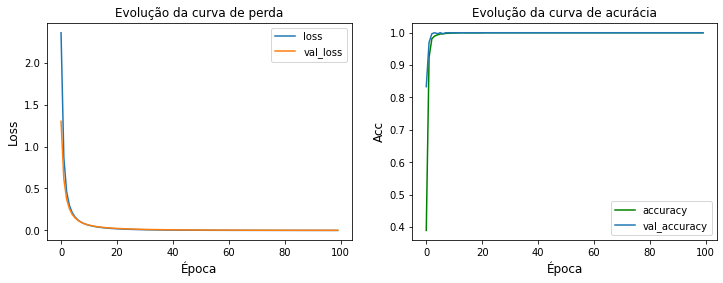

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = DenseNet169_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (DenseNet169_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 9s 117ms/step - loss: 7.1045e-04 - accuracy: 1.0000

accuracy : 100.00%


#### Random Initialization

In [ ]:
# prepare the images for the DenseNet model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze.
               0 = all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    densenet_model = DenseNet169(include_top=True,
                     weights=None,
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    # Turn all the layers trainable.

    for layer in densenet_model.layers:
      layer.trainable = True

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = densenet_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)

    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=densenet_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
DenseNet169_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)

In [ ]:
print(DenseNet169_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_densenet169_rdn.weights.best.hdf5', save_best_only=True, verbose=0)
history = DenseNet169_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 165s 311ms/step - loss: 0.8131 - accuracy: 0.7884 - val_loss: 5.4807 - val_accuracy: 0.0387
Epoch 2/100
189/189 [==============================] - 54s 287ms/step - loss: 0.1844 - accuracy: 0.9521 - val_loss: 3.5323 - val_accuracy: 0.3125
Epoch 3/100
189/189 [==============================] - 52s 274ms/step - loss: 0.1093 - accuracy: 0.9699 - val_loss: 0.1033 - val_accuracy: 0.9554
Epoch 4/100
189/189 [==============================] - 45s 237ms/step - loss: 0.0800 - accuracy: 0.9808 - val_loss: 0.2757 - val_accuracy: 0.9048
Epoch 5/100
189/189 [==============================] - 52s 274ms/step - loss: 0.0435 - accuracy: 0.9891 - val_loss: 0.0389 - val_accuracy: 0.9792
Epoch 6/100
189/189 [==============================] - 45s 237ms/step - loss: 0.0572 - accuracy: 0.9848 - val_loss: 0.5021 - val_accuracy: 0.8869
Epoch 7/100
189/189 [==============================] - 43s 226ms/step - loss: 0.0494 - accuracy: 0.9891 - val_loss: 0.1322 

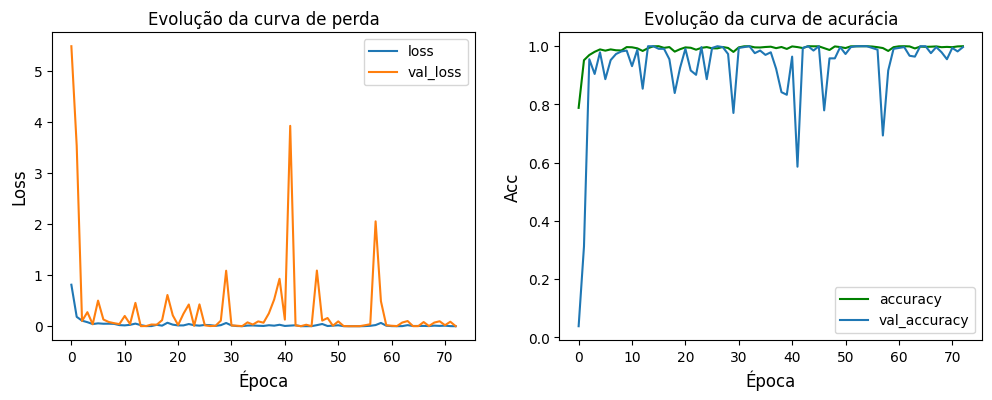

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = DenseNet169_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (DenseNet169_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 10s 116ms/step - loss: 6.4309e-04 - accuracy: 1.0000

accuracy : 100.00%
